In [134]:
# import dependancies
from sqlalchemy import create_engine, Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import Session
import matplotlib.pyplot as plt
from dateutil import parser
from dateutil.relativedelta import relativedelta
import pandas
from flask import jsonify

In [11]:
# declare constants
BASE = declarative_base()
ENGINE = create_engine('sqlite:///hawaii.sqlite')

In [112]:
# define functions

def preferences(data):
    """takes a ton of data, returns a value representing how good a day that is based on preference parameters"""
    result = 0
    # temperature preferences
    # min/max is room temperature
    MIN = 59
    MAX = 77
    # constant for "T1" days- days outside of temp range, but still acceptable
    T1 = (MAX - ((MIN + MAX) / 2))
    # precipitation is good, mmkay? this constant says how good. adjust as needed
    
    PREC = T1 * 1.5
    # add precipitation preference
    result = result + ((ball["prcp"][ball.prcp > 0].count() / data["prcp"].count()) * PREC)
    # subtract temperature preferences
    result = result - ((data["tobs"][((data.tobs > MAX) & (data.tobs > MAX + T1)) | ((data.tobs < MIN) & (data.tobs > MIN - T1))].count() / data["tobs"].count()) * T1)
    result = result - ((data["tobs"][(data.tobs > MAX + T1) | (data.tobs < MIN - T1)].count() / data["tobs"].count()) * (T1 * 2))
    return result
    

def opt_date(pref):
    """runs run_temps recursively and picks the optimal date to start the vacation from it"""
    result = {
        "date": [],
        "pref": []
    }
    for month in range(1, 12):
        if month < 9:
            month = f"0{month + 1}"
        else:
            month = str(month + 1)
        for day in range(30):
            if day < 9:
                date = f"0000-{month}-0{day + 1}"
            else:
                date = f"0000-{month}-{day + 1}"
            result["date"].append(date)
            result["pref"].append(pref(run_temps(date)))
    return pandas.DataFrame(result)

def run_temp(date):
    """takes a str in the format yyyy-mm-dd"""
    # result = str(parser.parse(date) + relativedelta(day=15))[:-9]
    result = date.split("-")
    result = f"{result[1]}-{result[2]}"
    # return(result)
    result = pandas.read_sql_query(f"""
    select tobs,
        prcp
    from measurements
    where substr(date, 6) = "{result}"
    """, ENGINE)
    return(result)

def calc_temps(date):
    """does run temp repeatedly to get data for a range of dates equal to {date} + 15 days"""
    result = pandas.DataFrame()
    for each in range(15):
        if each > 1:
            date = str(parser.parse(date) + relativedelta(day=1))[:-9]
            result.append(run_temps(date))
        else:
            result = run_temps(date)
    result = result.describe()["tobs"]
    result = {
        "min": result["min"],
        "average": result["mean"],
        "max": result["max"]
    }
    return result

In [109]:
opt_date(preferences).sort_values("pref", ascending = False).head()

C:\Users\Adam\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in long_scalars
  app.launch_new_instance()
C:\Users\Adam\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Adam\Anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


,date,pref
28,0000-02-29,18.000000
324,0000-12-25,6.750000
320,0000-12-21,6.279070
329,0000-12-30,6.136364
248,0000-10-09,6.136364


In [114]:
run_temp("2018-12-25").describe()

,tobs,prcp
count,40.000000,40.000000
mean,71.750000,0.284500
std,4.354485,0.686474
min,60.000000,0.000000
25%,69.750000,0.000000
50%,73.000000,0.030000
75%,74.000000,0.262500
max,79.000000,3.140000


In [105]:
pandas.read_sql_query("""
    select date, prcp
    from measurements
    where date > "2017-02-01"
    order by date desc
    """, ENGINE).head()

,date,prcp
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00


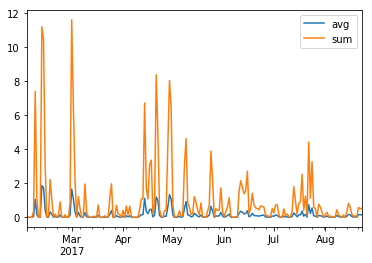

In [22]:
ball = pandas.read_sql_query("""
    select date, prcp
    from measurements
    where date > "2017-02-01"
    order by date desc
    """, ENGINE)
result = {"sum": {}, "avg": {}}
for each in ball["date"].unique():
    result["sum"][parser.parse(each)] = ball.loc[ball["date"] == each]["prcp"].sum()
    result["avg"][parser.parse(each)] = ball.loc[ball["date"] == each]["prcp"].mean()
result = pandas.DataFrame(result)
result.plot()
plt.show()

In [21]:
result = pandas.read_sql_query("""select date, prcp
    from measurements
    order by date desc
    """, ENGINE)
result.describe()

,prcp
count,19550.000000
mean,0.148753
std,0.453021
min,0.000000
25%,0.000000
50%,0.010000
75%,0.090000
max,11.530000


In [20]:
pandas.read_sql_query("""
    select stations.station,
        name
    from stations
        join measurements on stations.station = measurements.station
    group by name
    order by count(name) desc
    """, ENGINE)

,station,name
0,USC00519281,"WAIHEE 837.5, HI US"
1,USC00519397,"WAIKIKI 717.2, HI US"
2,USC00513117,"KANEOHE 838.1, HI US"
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
4,USC00516128,"MANOA LYON ARBO 785.2, HI US"
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
7,USC00517948,"PEARL CITY, HI US"
8,USC00518838,"UPPER WAHIAWA 874.3, HI US"


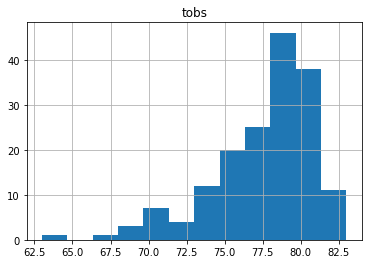

In [24]:
ball = pandas.read_sql_query("""
    select
        measurements.date,
            tobs
    from measurements
        join stations on stations.station = measurements.station
    where measurements.date > "2017-02-01"
        and stations.station = "USC00514830"
    order by date desc
    """, ENGINE)
ball.hist(bins = 12)
plt.show()

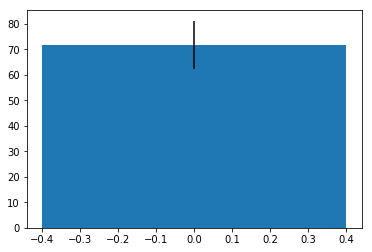

In [122]:
ball = calc_temps("2018-12-25")
ball["dev"] = ((ball["average"] - ball["min"]) + (ball["max"] - ball["average"])) / 2
plt.bar(0, ball["average"], yerr = ball["dev"])
plt.show()